In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from tempfile import TemporaryDirectory

import matplotlib as mpl
import seaborn as sns
import torch
import wandb
from matplotlib import pyplot as plt

import opf
import opf.utils
import opf.dataset
from opf.hetero import HeteroGCN
from opf.modules import OPFLogBarrier, OPFDual

mpl.rcParams["text.usetex"] = False

sns.set_style("white")
sns.set_context("paper")

torch.set_float32_matmul_precision("medium")

In [6]:
run_uri = "wandb://katyamaz/opf/4bjx47m5"

In [7]:
base, path = run_uri.split("://")
if base != "wandb":
    raise ValueError("Only wandb runs are supported")

api = wandb.Api()
run = api.run(path)
run.config.update(data_dir="../data")

# initialize data
dm = opf.dataset.CaseDataModule(**run.config)
dm.setup("test")
assert dm.test_dataset is not None

# initialize model and initialize lazy layers
barrier = OPFDual(
    **run.config, model=HeteroGCN(dm.metadata(), -1, 4, **run.config)
)
barrier(dm.test_dataset[0])

# load checkpoint
with TemporaryDirectory() as tmpdir:
    artifact = api.artifact(f"katyamaz/opf/model-{run.id}:best")
    checkpoint_path = artifact.download(root=tmpdir)
    checkpoint = torch.load(Path(checkpoint_path) / "model.ckpt", map_location="cpu")
    barrier.load_state_dict(checkpoint["state_dict"], strict=True)

/home/kmazu/.pyenv/versions/3.11.8/envs/opf/lib/python3.11/site-packages/torch_sparse/tensor.py:574: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(rowptr, col, value, self.sizes())
wandb:   1 of 1 files downloaded.  


In [8]:
# save_dir = f"./figures/{run.config['case_name']}/"
# os.makedirs(save_dir, exist_ok=True)


def save(title: str, fig=plt):
    pass
    # fig.savefig(save_dir + f"{title}.png")
    # fig.savefig(save_dir + f"{title}.pdf")

In [9]:
# Run test
barrier.detailed_metrics = True
outputs = opf.utils.test(barrier, dm, accelerator="gpu")

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/kmazu/.pyenv/versions/3.11.8/envs/opf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

The problem was not solved to optimality: LOCALLY_INFEASIBLE
The problem was not solved to optimality: LOCALLY_INFEASIBLE
The problem was not solved to optimality: LOCALLY_INFEASIBLE
The problem was not solved to optimality: LOCALLY_INFEASIBLE
The problem was not solved to optimality: LOCALLY_INFEASIBLE
The problem was not solved to optimality: LOCALLY_INFEASIBLE
The problem was not solved to optimality: LOCALLY_INFEASIBLE
The problem was not solved to optimality: LOCALLY_INFEASIBLE
The problem was not solved to optimality: LOCALLY_INFEASIBLE
The problem was not solved to optimality: LOCALLY_INFEASIBLE
The problem was not solved to optimality: LOCALLY_INFEASIBLE
The problem was not solved to optimality: LOCALLY_INFEASIBLE
The problem was not solved to optimality: LOCALLY_INFEASIBLE
The problem was not solved to optimality: LOCALLY_INFEASIBLE
The problem was not solved to optimality: LOCALLY_INFEASIBLE
The problem was not solved to optimality: LOCALLY_INFEASIBLE
The problem was not solv

# Summary

In [10]:
df = outputs.copy()
display(
    df[
        [
            "test/equality/error_max",
            "test/inequality/error_max",
            "test/inequality/active_power/error_max",
            "test/inequality/reactive_power/error_max",
            "test/inequality/voltage_magnitude/error_max",
            "test/inequality/forward_rate/error_max",
            "test/inequality/backward_rate/error_max",
            "test/inequality/voltage_angle_difference/error_max",
        ]
    ].max()
)

print(
    f"""
GNN Cost: {df["test/cost"].mean():0.4f}

Maximum violation rate: {df["test/inequality/rate"].max():0.4f}
Rate of any violation: {(df["test/inequality/error_max"] > 1e-4).sum() / len(df):0.4f}
"""
)
# not implemented right now
# IPOPT Cost: {df["acopf/cost"].mean():0.4f}
# GNN/IPOPT: {(df["test/cost"]/df["acopf/cost"]).mean():0.4f}

test/equality/error_max                               14.093775
test/inequality/error_max                              8.833337
test/inequality/active_power/error_max                 1.007141
test/inequality/reactive_power/error_max               2.759264
test/inequality/voltage_magnitude/error_max            8.833337
test/inequality/forward_rate/error_max                 5.250587
test/inequality/backward_rate/error_max                6.780152
test/inequality/voltage_angle_difference/error_max     3.500000
dtype: float64


GNN Cost: 0.1286

Maximum violation rate: 0.8207
Rate of any violation: 1.0000



# Histograms

/home/kmazu/.pyenv/versions/3.11.8/envs/opf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kmazu/.pyenv/versions/3.11.8/envs/opf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kmazu/.pyenv/versions/3.11.8/envs/opf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kmazu/.pyenv/versions/3.11.8/envs/opf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning


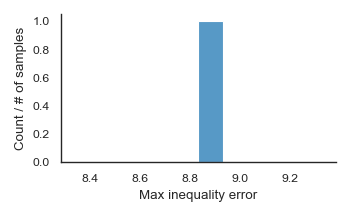
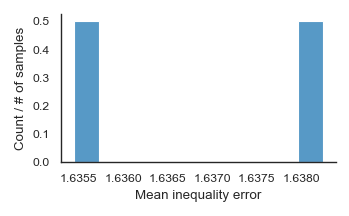
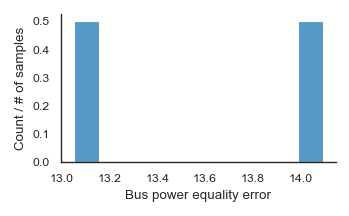
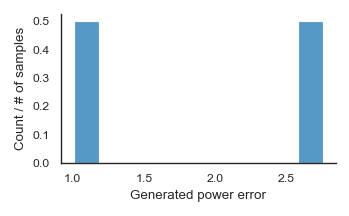
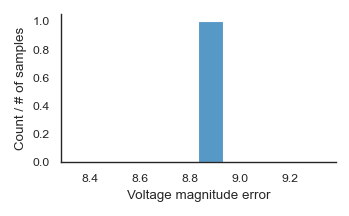
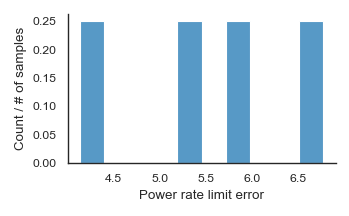
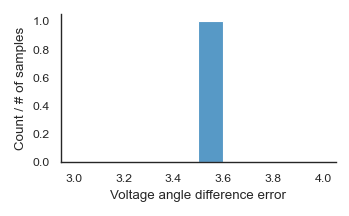

In [11]:
from opf.utils import FlowLayout

aspect = 1.618
ylabel = "Count / # of samples"
kwargs = dict(
    bins=10,
    stat="proportion",
    aspect=aspect,
    height=3.5 / aspect,
)


sns.displot(df, x="test/inequality/error_max", **kwargs)
plt.xlabel("Max inequality error")
plt.ylabel(ylabel)
save("error_max")

sns.displot(df, x="test/inequality/error_mean", **kwargs)
plt.xlabel("Mean inequality error")
plt.ylabel(ylabel)
save("error_mean")

# Cost improvement
# df["test/cost/improvement"] = df["test/cost"] / df["acopf/cost"]
# df["violation"] = df["test/inequality/rate"] > 1e-8
# sns.displot(df[~df["violation"]], x="test/cost/improvement", **kwargs)
# plt.xlabel("GNN / IPOPT cost ratio")
# plt.ylabel(ylabel)
# save("costs")

# map variable names to series names
fmt = "test/inequality/%s/error_max"
hist_dict = {
    "equality": ["test/equality/bus_power/error_max"],
    "gen": [fmt % "active_power", fmt % "reactive_power"],
    "vm": [fmt % "voltage_magnitude"],
    "rate": [fmt % "forward_rate", fmt % "backward_rate"],
    "vad": [fmt % "voltage_angle_difference"],
}

sns.displot(df["test/equality/bus_power/error_max"], **kwargs)
plt.xlabel("Bus power equality error")
plt.ylabel(ylabel)
save("error_equality")

power_df = df.melt(value_vars=[fmt % "active_power", fmt % "reactive_power"])
sns.displot(power_df, x="value", **kwargs)
plt.xlabel("Generated power error")
plt.ylabel(ylabel)
save("error_gen")

sns.displot(df[fmt % "voltage_magnitude"], **kwargs)
plt.xlabel("Voltage magnitude error")
plt.ylabel(ylabel)
save("error_vm")

flow_df = df.melt(value_vars=[fmt % "forward_rate", fmt % "backward_rate"])
sns.displot(flow_df, x="value", **kwargs)
plt.xlabel("Power rate limit error")
plt.ylabel(ylabel)
save("error_rate")

sns.displot(df[fmt % "voltage_angle_difference"], **kwargs)
plt.xlabel("Voltage angle difference error")
plt.ylabel(ylabel)
save("error_vad")

FlowLayout().all_open()

# Visualizing Violations

In [13]:
sort_term = "test/inequality/error_max"
quantile = 0.5

s = df[sort_term]
index = int((s.sort_values()[::-1] <= s.quantile(quantile)).idxmax())
print(sort_term, s[index])
print("Idx", index)
df.iloc[index][
    [
        "test/cost",
        "test/equality/bus_power/error_max",
        "test/equality/bus_reference/error_max",
        "test/inequality/error_max",
        "test/inequality/active_power/error_max",
        "test/inequality/reactive_power/error_max",
        "test/inequality/voltage_magnitude/error_max",
        "test/inequality/forward_rate/error_max",
        "test/inequality/backward_rate/error_max",
        "test/inequality/voltage_angle_difference/error_max",
    ]
]

test/inequality/error_max 8.83333683013916
Idx 1


test/cost                                              0.128598
test/equality/bus_power/error_max                     13.050061
test/equality/bus_reference/error_max                  0.000000
test/inequality/error_max                              8.833337
test/inequality/active_power/error_max                 1.007141
test/inequality/reactive_power/error_max               2.759264
test/inequality/voltage_magnitude/error_max            8.833337
test/inequality/forward_rate/error_max                 4.134126
test/inequality/backward_rate/error_max                5.801137
test/inequality/voltage_angle_difference/error_max     3.500000
Name: 1, dtype: float64

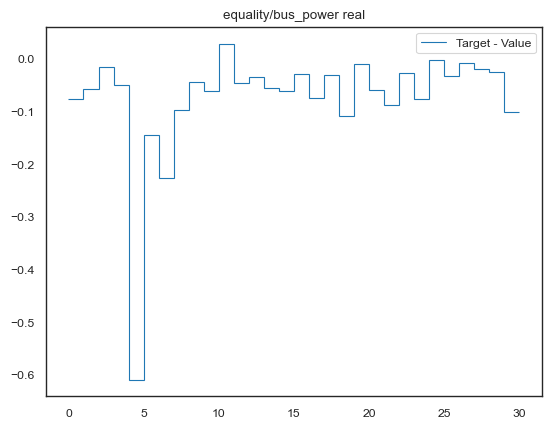

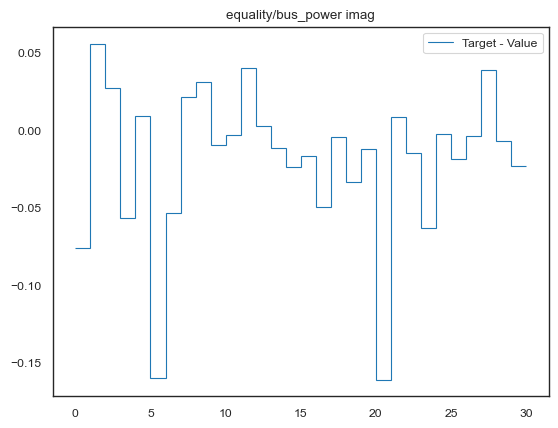

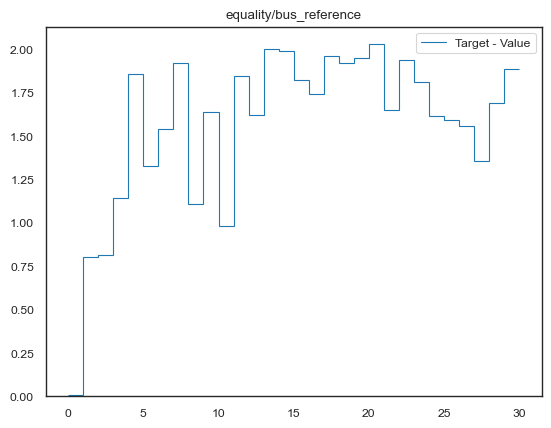

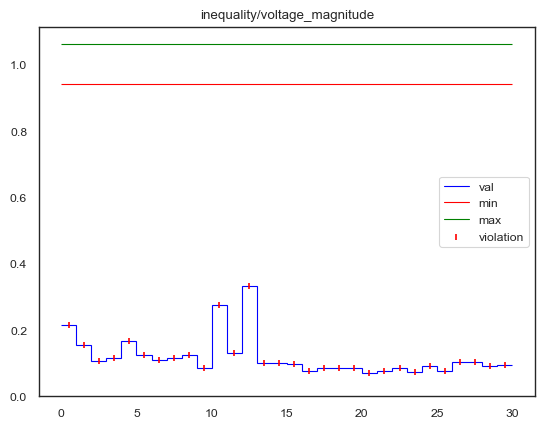

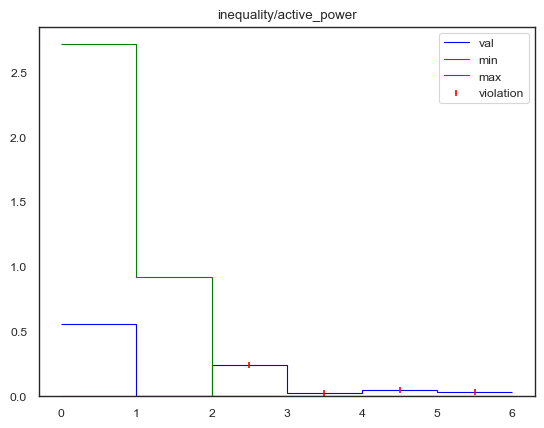

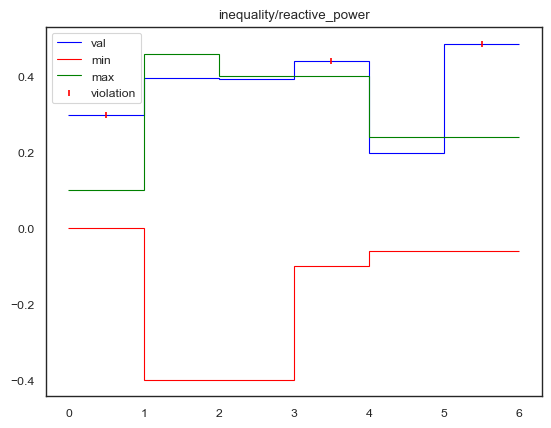

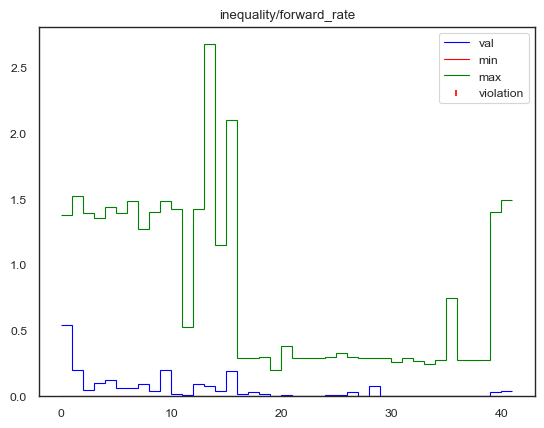

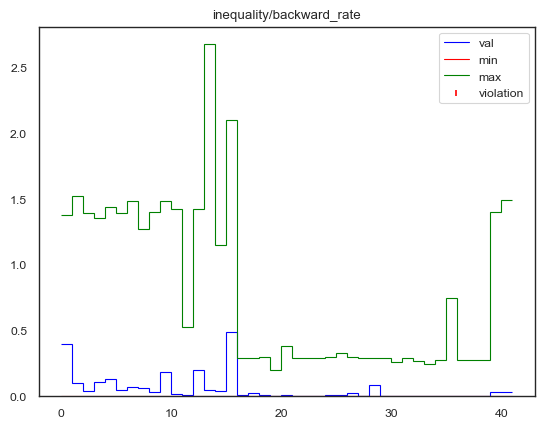

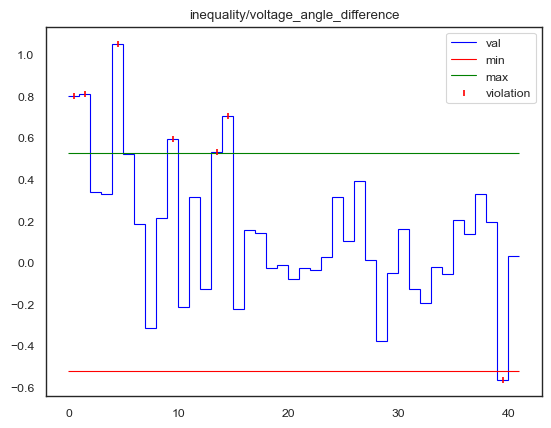

In [14]:
# perform inference on the test set
from opf.plot import plot_constraints
import opf.powerflow as pf

with torch.no_grad():
    dm.setup("test")
    dataset = dm.test_dataset
    # assert isinstance(dataset, opf.dataset.StaticGraphDataset)
    data = dataset[index]
    V, S, Sd = barrier.float()(data)
    # substitute_equality was True
    variables, _, _, _ = barrier._step_helper(
        V, S, Sd, data.powerflow_parameters, substitute_equality=False
    )
    constraints = pf.build_constraints(variables, data.powerflow_parameters)
    plots = plot_constraints(constraints)

In [12]:
import numpy as np

dataset = dm.test_dataset
# assert isinstance(dataset, opf.dataset.StaticGraphDataset)

n_bus = dataset[0].powerflow_parameters.n_bus
n_gen = dataset[0].powerflow_parameters.n_gen
casefile = dm.case_path.as_posix()

V = np.zeros((len(dataset), n_bus, 2))
Sg = np.zeros((len(dataset), n_gen, 2))
Sd = np.zeros((len(dataset), n_bus, 2))
with torch.no_grad():
    for i in range(len(dataset)):
        data = dataset[i]
        _V, _Sg, _Sd = barrier.float()(data)
        V[i, :] = torch.view_as_real(_V).squeeze().numpy()
        Sg[i, :] = torch.view_as_real(_Sg).squeeze().numpy()
        Sd[i, :] = torch.view_as_real(_Sd).squeeze().numpy()

# project using Julia
with TemporaryDirectory() as tempdir:
    busfile = Path(tempdir) / "busfile.npz"
    np.savez(busfile, V=V, Sg=Sg, Sd=Sd)
    !julia ../scripts/project.jl --casefile {casefile} --busfile {busfile.as_posix()}
    bus = np.load(busfile)
V, Sg, Sd = bus["V"], bus["Sg"], bus["Sd"]

]0;Julia]0;JuliaERROR: SystemError: opening file "/home/kmazu/opf/scripts/project.jl": No such file or directory
Stacktrace:
  [1] systemerror(p::String, errno::Int32; extrainfo::Nothing)
    @ Base ./error.jl:176
  [2] #systemerror#82
    @ ./error.jl:175 [inlined]
  [3] systemerror
    @ ./error.jl:175 [inlined]
  [4] open(fname::String; lock::Bool, read::Nothing, write::Nothing, create::Nothing, truncate::Nothing, append::Nothing)
    @ Base ./iostream.jl:293
  [5] open
    @ ./iostream.jl:275 [inlined]
  [6] open(f::Base.var"#418#419"{String}, args::String; kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ Base ./io.jl:393
  [7] open
    @ ./io.jl:392 [inlined]
  [8] read
    @ ./io.jl:473 [inlined]
  [9] _include(mapexpr::Function, mod::Module, _path::String)
    @ Base ./loading.jl:1959
 [10] include(mod::Module, _path::String)
    @ Base ./Base.jl:457
 [11] exec_options(opts::Base.JLOptions)
    @ Base ./client.jl:307
 [12] _start()
    @ Base ./cl

In [13]:
df["acopf/cost/relaxed"] = None
for i in tqdm.tqdm(range(len(df))):
    forward_error = df.iloc[i]["test/inequality/forward_rate/error_max"]
    backward_error = df.iloc[i]["test/inequality/backward_rate/error_max"]

    increase = 1 + torch.clamp((torch.maximum(variables.Sf.abs(), variables.St.abs()) - barrier.powerflow_parameters.rate_a) / barrier.powerflow_parameters.rate_a, min=0) \
        .squeeze().detach().numpy()
    net = barrier.net_wrapper.net
    original = net.line.copy()
    barrier.net_wrapper.set_load_sparse(variables.Sd.real.squeeze(), variables.Sd.imag.squeeze())

    net.line["max_i_ka"] *= increase[:len(net.line)]
    bus = torch.as_tensor(barrier.net_wrapper.optimal_ac(False)[0]).double().unsqueeze(0)
    _, constraints, cost, _ = barrier._step_helper(
                    *barrier.parse_bus(bus),
                    variables.Sd,
                    project_pandapower=False,
    )
    net.line = original
    df["acopf/cost/relaxed"].iloc[i] = cost.item()
print("IPOPT Original Cost:", df["acopf/cost"].mean())
print("IPOPT Relaxed Cost:", df["acopf/cost/relaxed"].mean())
print("GNN Cost", df["test/cost"].mean())

NameError: name 'tqdm' is not defined